# Unsupervised Learning Capstone

For your third capstone, you’ll complete an unsupervised learning project. You can choose your own research question or choose from one below.

Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.

Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

Things to keep in mind: how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?

Be prepared to talk about:

Your end-user and the value your project provides to them. <br>
Quantifiable results based on the research you’ve conducted.<br>
The visuals you chose and what they represent for your research.<br>
Next steps you'd take to expand on your work.<br>
A specified research question your model addresses.<br>
How you chose your model specification and what alternatives you compared it to.<br>
The practical uses of your model for an audience of interest.<br>
Any weak points or shortcomings of your model.<br>

# The Data

I've chosen to explore and analze data on [animal disease outbreaks](https://www.kaggle.com/tentotheminus9/empres-global-animal-disease-surveillance) found on Kaggle gathered by EMPRES Global Animal Disease Information System (EMPRES-i), an application created to assist veterinary services by providing information on global diseases. The ability to understand the inception and spread of these diseases and ultimately predict where and how future incidents/episodes will unfold is crucial in our efforts to combat the damage caused. While some may believe animals' health is irrelevant to us, this couldn't be farther from the truth - on an obvious level, because roughly 90% of the world's population eats meat it is advantageous for us to keep our fellow animals healthy. What is less known but perhaps even more important is that many epidemiologists believe it's likely that the next pandemic will come from an animal, similar to the SARS and MERS viruses that have killed hundreds.

The data includes just over 17,000 cases of animal outbreaks. Each row represents a different outbreak so there are some repeating diseases. Variables include timing, place, species, and diseases, as well as information on the number of animals and humans affected. I'll use clutering and other unsupervised learning in an effort to learn about the onset and dispersion of animal disease outbreaks. Ideally, the data will collect in such a way that I am able to differentiate/locate/predict outbreaks with pandemic potential. 

In [109]:
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
%matplotlib inline
from datetime import datetime, timedelta
import re


# from matplotlib import image
from sklearn.preprocessing import StandardScaler, normalize
from scipy.stats.mstats import winsorize
import scipy.stats as stats

# from keras.layers import Input,Dense
# from keras.models import Model

# import keras
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE
# import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn import datasets, metrics
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage as lnkg

# from sklearn.neural_network import MLPClassifier, BernoulliRBM
# from sklearn import ensemble
# from sklearn.model_selection import cross_val_score, GridSearchCV

In [60]:
outbreaks = pd.read_csv('animal_outbreaks.csv')
outbreaks = pd.DataFrame(outbreaks)
print(outbreaks.columns)
print(outbreaks.info())

Index(['Id', 'source', 'latitude', 'longitude', 'region', 'country', 'admin1',
       'localityName', 'localityQuality', 'observationDate', 'reportingDate',
       'status', 'disease', 'serotypes', 'speciesDescription', 'sumAtRisk',
       'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered',
       'humansGenderDesc', 'humansAge', 'humansAffected', 'humansDeaths'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17008 entries, 0 to 17007
Data columns (total 24 columns):
Id                    17008 non-null int64
source                17008 non-null object
latitude              17008 non-null float64
longitude             17008 non-null float64
region                17008 non-null object
country               17008 non-null object
admin1                17008 non-null object
localityName          17008 non-null object
localityQuality       17008 non-null object
observationDate       16506 non-null object
reportingDate         17008 non-null object
status    

In [61]:
print(outbreaks.humansAffected.value_counts())
print(outbreaks.humansDeaths.value_counts())

1.0     1411
0.0        3
24.0       1
3.0        1
4.0        1
Name: humansAffected, dtype: int64
1.0    399
0.0     51
2.0      1
Name: humansDeaths, dtype: int64


# The Cleaning

More than half of the variables are not missing any data which is a great start. Just under 7,000 rows are missing information on serotypes so I will fill these with 'Uknown Serotypes'. Similarly, under 2,000 rows are missing in speciesDescription, so these will be filled with 'Unknown Species'. Additionally, the information populating these cells are lists of animals so I will create new dummy variables with keywords, including 'wild' and 'domestic'. Finally, I'll create new features 'birds' and 'mammals' which will indicate whether a disease affected these classes.

Empty cells in sumAtRisk, sumCases, sumDeaths, sumDestroyed, sumSlaughtered, and humansAge will be filled with the mean value of these columns. I will drop the column humansGenderDesc as there is simply not enough information for me to populate the missing values. As for humansAffected and humansDeaths, I'll populate missing values with the mode. 

All dates in the data will be converted to datetime objects and create variables for the year, month, and day of the observation. Missing variables in observationDate will be filled by finding the average difference between the observationDate and reportingDate, and subtracting this number from the reportingDate. A new variable, 'differenceInDays', will be created by finding the difference between the observationDate and reportingDate for each instance.

Dummies will be created for source, region, country, localityQuality, disease, serotypes, and status.

In [62]:
outbreaks.serotypes.fillna('Uknown Serotypes', inplace=True)
outbreaks.speciesDescription.fillna('Uknown Species', inplace=True)
outbreaks.sumAtRisk.fillna(outbreaks.sumAtRisk.mean(), inplace=True)
outbreaks.sumCases.fillna(outbreaks.sumCases.mean(), inplace=True)
outbreaks.sumDeaths.fillna(outbreaks.sumDeaths.mean(), inplace=True)
outbreaks.sumDestroyed.fillna(outbreaks.sumDestroyed.mean(), inplace=True)
outbreaks.sumSlaughtered.fillna(outbreaks.sumSlaughtered.mean(), inplace=True)
outbreaks.drop(columns=['humansGenderDesc'], inplace=True)
outbreaks.humansAge.fillna(outbreaks.humansAge.mean(), inplace=True)
outbreaks.humansAffected.fillna(outbreaks.humansAffected.mode()[0], inplace=True)
outbreaks.humansDeaths.fillna(outbreaks.humansDeaths.mode()[0], inplace=True)

In [63]:
print('Reporting Dates: \n', outbreaks.reportingDate.head())
print('Observation Dates: \n', outbreaks.observationDate.head())

Reporting Dates: 
 0    22/08/2017
1    18/08/2017
2    16/08/2017
3    22/08/2017
4    17/08/2017
Name: reportingDate, dtype: object
Observation Dates: 
 0    17/08/2017
1    16/08/2017
2    16/08/2017
3    15/08/2017
4    15/08/2017
Name: observationDate, dtype: object


In [64]:
# Creating a new dataframe to handle the dates
outbreaks['observationDate'] = pd.to_datetime(outbreaks['observationDate'])
outbreaks['reportingDate'] = pd.to_datetime(outbreaks['reportingDate'])
outbreaks_time = outbreaks[['observationDate', 'reportingDate']]
outbreaks_time.dropna(inplace=True)

# Find the average difference between observation and reporting dates
outbreaks_time['differenceInDays'] = (outbreaks_time['reportingDate'] - outbreaks_time['observationDate'])/np.timedelta64(1,'D')
                                                                     
print('Average difference between observation and reporting dates: ', outbreaks_time['differenceInDays'].mean())
outbreaks.observationDate.fillna(outbreaks.reportingDate - timedelta(days=33), inplace=True)

# Creating a new variable
outbreaks['differenceInDays'] = (outbreaks['reportingDate'] - outbreaks['observationDate'])/np.timedelta64(1,'D')

Average difference between observation and reporting dates:  33.20907548770144


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
outbreaks.differenceInDays.head()

0    5.0
1    2.0
2    0.0
3    7.0
4    2.0
Name: differenceInDays, dtype: float64

In [66]:
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17008 entries, 0 to 17007
Data columns (total 24 columns):
Id                    17008 non-null int64
source                17008 non-null object
latitude              17008 non-null float64
longitude             17008 non-null float64
region                17008 non-null object
country               17008 non-null object
admin1                17008 non-null object
localityName          17008 non-null object
localityQuality       17008 non-null object
observationDate       17008 non-null datetime64[ns]
reportingDate         17008 non-null datetime64[ns]
status                17008 non-null object
disease               17008 non-null object
serotypes             17008 non-null object
speciesDescription    17008 non-null object
sumAtRisk             17008 non-null float64
sumCases              17008 non-null float64
sumDeaths             17008 non-null float64
sumDestroyed          17008 non-null float64
sumSlaughtered        17008 non-nu

In [67]:
outbreaks['observationYear'] = pd.DatetimeIndex(outbreaks['observationDate']).year
outbreaks['observationMonth'] = pd.DatetimeIndex(outbreaks['observationDate']).month
outbreaks['observationDay'] = pd.DatetimeIndex(outbreaks['observationDate']).day
outbreaks['observationFirstHalfMonth'] = outbreaks['observationDay'].apply(lambda x: 1 if x <= 15 else 0 )
outbreaks['observationSecondHalfMonth'] = outbreaks['observationDay'].apply(lambda x: 1 if x > 15 else 0 )

In [68]:
pd.options.display.max_columns = None
outbreaks.head()

,Id,source,latitude,longitude,region,country,admin1,localityName,localityQuality,observationDate,reportingDate,status,disease,serotypes,speciesDescription,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansAge,humansAffected,humansDeaths,differenceInDays,observationYear,observationMonth,observationDay,observationFirstHalfMonth,observationSecondHalfMonth
0,230399,OIE,-27.900000,30.800000,Africa,South Africa,KwaZulu-Natal,HPAI_H5N8_2017_019,Exact,2017-08-17,2017-08-22,Confirmed,Influenza - Avian,H5N8 HPAI,"domestic, unspecified bird",248000.000000,12.0,12.0,50000.000000,0.000000,0.000000,1.0,1.0,5.0,2017,8,17,0,1
1,230381,OIE,54.837037,73.354155,Europe,Russian Federation,Omskaya Oblast,Novaya Stanica,Exact,2017-08-16,2017-08-18,Confirmed,African swine fever,Uknown Serotypes,"domestic, swine",122.000000,6.0,1.0,0.000000,0.000000,17.701311,1.0,1.0,2.0,2017,8,16,0,1
2,230333,OIE,-21.077740,30.211620,Africa,Zimbabwe,Masvingo,Mwambe,Exact,2017-08-16,2017-08-16,Confirmed,Foot and mouth disease,Uknown Serotypes,"domestic, cattle",1283.000000,112.0,0.0,3765.857978,7.000000,17.701311,1.0,1.0,0.0,2017,8,16,0,1
3,230396,OIE,-26.000000,28.300000,Africa,South Africa,Gauteng,HPAI_H5N8_2017_020,Exact,2017-08-15,2017-08-22,Confirmed,Influenza - Avian,H5N8 HPAI,"wild, unspecified bird",7500.691709,1.0,1.0,0.000000,0.000000,0.000000,1.0,1.0,7.0,2017,8,15,1,0
4,230371,OIE,49.237900,17.700200,Europe,Czech Republic,Jihomoravsky,HvozdnÃ¡,Exact,2017-08-15,2017-08-17,Confirmed,African swine fever,Uknown Serotypes,"wild, wild boar",7500.691709,1.0,1.0,3765.857978,100.211443,17.701311,1.0,1.0,2.0,2017,8,15,1,0


In [69]:
print('Unique values in source: ', len(outbreaks.source.unique()))
print('Unique values in region: ', len(outbreaks.region.unique()))
print('Unique values in country: ', len(outbreaks.country.unique()))
print('Unique values in admin1: ', len(outbreaks.admin1.unique()))
print('Unique values in localityName: ', len(outbreaks.localityName.unique()))
print('Unique values in localityQuality: ', len(outbreaks.localityQuality.unique()))
print('Unique values in status: ', len(outbreaks.status.unique()))
print('Unique values in disease: ', len(outbreaks.disease.unique()))
print('Unique values in serotypes: ', len(outbreaks.serotypes.unique()))
print('Unique values in speciesDescription: ', len(outbreaks.speciesDescription.unique()))

Unique values in source:  12
Unique values in region:  4
Unique values in country:  122
Unique values in admin1:  941
Unique values in localityName:  9279
Unique values in localityQuality:  5
Unique values in status:  2
Unique values in disease:  26
Unique values in serotypes:  61
Unique values in speciesDescription:  289


In [70]:
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['source'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['region'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['country'])], axis=1)
outbreaks.drop(columns=['admin1', 'localityName'], inplace=True)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['localityQuality'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['status'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['disease'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['serotypes'])], axis=1)

In [71]:
outbreaks['wild'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'wild' in x else 0)
outbreaks['undomestic'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'undomestic' in x else 0)
outbreaks['domestic'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'domestic' in x else 0)
outbreaks['captive'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'captive' in x else 0)
outbreaks['unspecified'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'unspecified' in x else 0)
outbreaks.head(10)

,Id,source,latitude,longitude,region,country,localityQuality,observationDate,reportingDate,status,disease,serotypes,speciesDescription,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansAge,humansAffected,humansDeaths,differenceInDays,observationYear,observationMonth,observationDay,observationFirstHalfMonth,observationSecondHalfMonth,EC,FAO Field Officer,FAO officer,FAO-Report,International reference laboratory,"National Institute for Communicable Diseases, NICD",National authorities,OIE,Other,Publications,WHO,sequence only,Africa,Americas,Asia,Europe,Albania,Algeria,Angola,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belgium,Belize,Benin,Bhutan,Bosnia and Herzegovina,Botswana,Brazil,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Chile,China,Colombia,Croatia,Cyprus,Czech Republic,CÃ´te d'Ivoire,Democratic Republic of the Congo,Denmark,Ecuador,Egypt,El Salvador,Estonia,Finland,France,French Guiana,Gambia,Gaza Strip,Georgia,Germany,Ghana,Greece,Guinea-Bissau,"Hong Kong, SAR",Hungary,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Libya,Lithuania,Luxembourg,Macau,Malawi,Malaysia,Maldives,Mali,Mauritania,Mauritius,Mexico,"Moldova, Republic of",Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Netherlands,Niger,Nigeria,Oman,Panama,Philippines,Poland,Portugal,Qatar,Republic of Korea,Romania,Russian Federation,Saudi Arabia,Senegal,Serbia,Slovakia,Slovenia,South Africa,Spain,Swaziland,Sweden,Switzerland,Syrian Arab Republic,Taiwan (Province of China),Thailand,The former Yugoslav Republic of Macedonia,Togo,Tunisia,Turkey,U.K. of Great Britain and Northern Ireland,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,United States of America,Uruguay,Viet Nam,West Bank,Zambia,Zimbabwe,Centroid Admin1,Centroid Admin2,Centroid Locality,Exact,Unknown,Confirmed,Denied,African horse sickness,African swine fever,Anthrax,Bluetongue,Bovine spongiform encephalopathy,Bovine tuberculosis,Brucellosis (Brucella abortus),Brucellosis (Brucella melitensis),Brucellosis (Brucella suis),Classical swine fever,Contagious bovine pleuropneumonia,Equine infectious anaemia,Foot and mouth disease,Glanders,Influenza - Avian,Influenza - Equine,Influenza - Swine,Lumpy skin disease,MERS-CoV,Newcastle disease,Peste des petits ruminants,Porcine reproductive and respiratory syndrome,Rabies,Rift Valley fever,Sheep pox and goat pox,West Nile Fever,1,13,14,18,19,22,3,4,7,8,A,APMV-I,Asia 1,H1N2,H3N8,H5 HPAI,H5 LPAI,H5N1 HPAI,"H5N1 HPAI, H5N2 HPAI","H5N1 HPAI, H5N6 HPAI",H5N1 LPAI,H5N2 HPAI,"H5N2 HPAI, H5N1 HPAI","H5N2 HPAI, H5N6 HPAI",H5N2 LPAI,H5N3 HPAI,H5N3 LPAI,H5N5 HPAI,H5N6 HPAI,"H5N6 HPAI, H5N1 HPAI","H5N6 HPAI, H5N1 HPAI, H5N2 HPAI","H5N6 HPAI, H5N2 HPAI","H5N6 HPAI, H5N2 HPAI, H5N1 HPAI","H5N6 HPAI, H5N6 HPAI","H5N6 HPAI, H5N8 HPAI",H5N6 LPAI,H5N8 HPAI,"H5N8 HPAI, H5N1 HPAI, H5N6 HPAI","H5N8 HPAI, H5N2 HPAI",H5N8 LPAI,H5N9 HPAI,H5N9 LPAI,H7 LPAI,H7N1 HPAI,H7N2 LPAI,H7N3 HPAI,H7N3 LPAI,H7N6 LPAI,H7N7 HPAI,H7N7 LPAI,H7N8 LPAI,H7N9 HPAI,H7N9 LPAI,H9N2 LPAI,HPAI,Not Specified,Not specified,O,SAT2,SAT3,Uknown Serotypes,wild,undomestic,domestic,captive,unspecified
0,230399,OIE,-27.900000,30.800000,Africa,South Africa,Exact,2017-08-17,2017-08-22,Confirmed,Influenza - Avian,H5N8 HPAI,"domestic, unspecified bird",248000.000000,12.0,12.0,50000.000000,0.000000,0.000000,1.0,1.0,5.0,2017,8,17,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,230381,OIE,54.837037,73.354155,Europe,Russian Fede

In [72]:
birds = ['bird', 'swan', 'turkey', 'mallard', 'goose', 'duck', 'pigeon', 'heron', 'accipitridae', 'gull', 
         'phasianidae', 'eagle', 'chicken', 'buzzard', 'falcon', 'anatidae', 'fowl', 'eider', 'pelican', 'wigeon',
        'dove', 'rook', 'stork', 'egret', ' peafowl', 'cormorant', 'coot', 'crow', 'scaup', 'teal', 'magpie', 
         'kestrel', 'blackbird', 'gadwall', 'pochard', 'shelduck', 'parrot', 'tern', ' grebe', 'flamingo', 'eagle-owl',
        'accipiter gentilis', 'ibis', 'ibex', 'emu', 'xpeacock', 'magpie-robin', ]
mammals = ['swine', 'boar', 'equidae', 'dog', 'sheep', 'cat', 'goat/sheep', 'goat', 'camelidae', 'horse',
          'fox', 'jackal', ' saiga', 'yaks', 'hippopotamus', 'buffaloe', 'deer', 'canine', 'elephant', 'mammal']

outbreaks['speciesDescription'] = outbreaks.speciesDescription.apply(lambda x: re.split('\s', x))
outbreaks['birds'] = outbreaks.speciesDescription.apply(lambda x: 1 if len(set(x) & set(birds)) > 0  else 0) 
outbreaks['mammals'] = outbreaks.speciesDescription.apply(lambda x: 1 if len(set(x) & set(mammals)) > 0  else 0)
outbreaks.head()

,Id,source,latitude,longitude,region,country,localityQuality,observationDate,reportingDate,status,disease,serotypes,speciesDescription,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansAge,humansAffected,humansDeaths,differenceInDays,observationYear,observationMonth,observationDay,observationFirstHalfMonth,observationSecondHalfMonth,EC,FAO Field Officer,FAO officer,FAO-Report,International reference laboratory,"National Institute for Communicable Diseases, NICD",National authorities,OIE,Other,Publications,WHO,sequence only,Africa,Americas,Asia,Europe,Albania,Algeria,Angola,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belgium,Belize,Benin,Bhutan,Bosnia and Herzegovina,Botswana,Brazil,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Chile,China,Colombia,Croatia,Cyprus,Czech Republic,CÃ´te d'Ivoire,Democratic Republic of the Congo,Denmark,Ecuador,Egypt,El Salvador,Estonia,Finland,France,French Guiana,Gambia,Gaza Strip,Georgia,Germany,Ghana,Greece,Guinea-Bissau,"Hong Kong, SAR",Hungary,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Libya,Lithuania,Luxembourg,Macau,Malawi,Malaysia,Maldives,Mali,Mauritania,Mauritius,Mexico,"Moldova, Republic of",Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Netherlands,Niger,Nigeria,Oman,Panama,Philippines,Poland,Portugal,Qatar,Republic of Korea,Romania,Russian Federation,Saudi Arabia,Senegal,Serbia,Slovakia,Slovenia,South Africa,Spain,Swaziland,Sweden,Switzerland,Syrian Arab Republic,Taiwan (Province of China),Thailand,The former Yugoslav Republic of Macedonia,Togo,Tunisia,Turkey,U.K. of Great Britain and Northern Ireland,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,United States of America,Uruguay,Viet Nam,West Bank,Zambia,Zimbabwe,Centroid Admin1,Centroid Admin2,Centroid Locality,Exact,Unknown,Confirmed,Denied,African horse sickness,African swine fever,Anthrax,Bluetongue,Bovine spongiform encephalopathy,Bovine tuberculosis,Brucellosis (Brucella abortus),Brucellosis (Brucella melitensis),Brucellosis (Brucella suis),Classical swine fever,Contagious bovine pleuropneumonia,Equine infectious anaemia,Foot and mouth disease,Glanders,Influenza - Avian,Influenza - Equine,Influenza - Swine,Lumpy skin disease,MERS-CoV,Newcastle disease,Peste des petits ruminants,Porcine reproductive and respiratory syndrome,Rabies,Rift Valley fever,Sheep pox and goat pox,West Nile Fever,1,13,14,18,19,22,3,4,7,8,A,APMV-I,Asia 1,H1N2,H3N8,H5 HPAI,H5 LPAI,H5N1 HPAI,"H5N1 HPAI, H5N2 HPAI","H5N1 HPAI, H5N6 HPAI",H5N1 LPAI,H5N2 HPAI,"H5N2 HPAI, H5N1 HPAI","H5N2 HPAI, H5N6 HPAI",H5N2 LPAI,H5N3 HPAI,H5N3 LPAI,H5N5 HPAI,H5N6 HPAI,"H5N6 HPAI, H5N1 HPAI","H5N6 HPAI, H5N1 HPAI, H5N2 HPAI","H5N6 HPAI, H5N2 HPAI","H5N6 HPAI, H5N2 HPAI, H5N1 HPAI","H5N6 HPAI, H5N6 HPAI","H5N6 HPAI, H5N8 HPAI",H5N6 LPAI,H5N8 HPAI,"H5N8 HPAI, H5N1 HPAI, H5N6 HPAI","H5N8 HPAI, H5N2 HPAI",H5N8 LPAI,H5N9 HPAI,H5N9 LPAI,H7 LPAI,H7N1 HPAI,H7N2 LPAI,H7N3 HPAI,H7N3 LPAI,H7N6 LPAI,H7N7 HPAI,H7N7 LPAI,H7N8 LPAI,H7N9 HPAI,H7N9 LPAI,H9N2 LPAI,HPAI,Not Specified,Not specified,O,SAT2,SAT3,Uknown Serotypes,wild,undomestic,domestic,captive,unspecified,birds,mammals
0,230399,OIE,-27.900000,30.800000,Africa,South Africa,Exact,2017-08-17,2017-08-22,Confirmed,Influenza - Avian,H5N8 HPAI,"[domestic,, unspecified, bird]",248000.000000,12.0,12.0,50000.000000,0.000000,0.000000,1.0,1.0,5.0,2017,8,17,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
1,230381,OIE,54.837037,73.3541

There are just over 3,700 entries with observationDate values after reportingDates. This is impossible, so I will delete these rows.

In [73]:
outbreaks[(outbreaks['birds'] == 1) & (outbreaks['mammals'] == 1 )]

,Id,source,latitude,longitude,region,country,localityQuality,observationDate,reportingDate,status,disease,serotypes,speciesDescription,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansAge,humansAffected,humansDeaths,differenceInDays,observationYear,observationMonth,observationDay,observationFirstHalfMonth,observationSecondHalfMonth,EC,FAO Field Officer,FAO officer,FAO-Report,International reference laboratory,"National Institute for Communicable Diseases, NICD",National authorities,OIE,Other,Publications,WHO,sequence only,Africa,Americas,Asia,Europe,Albania,Algeria,Angola,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belgium,Belize,Benin,Bhutan,Bosnia and Herzegovina,Botswana,Brazil,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Chile,China,Colombia,Croatia,Cyprus,Czech Republic,CÃ´te d'Ivoire,Democratic Republic of the Congo,Denmark,Ecuador,Egypt,El Salvador,Estonia,Finland,France,French Guiana,Gambia,Gaza Strip,Georgia,Germany,Ghana,Greece,Guinea-Bissau,"Hong Kong, SAR",Hungary,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Libya,Lithuania,Luxembourg,Macau,Malawi,Malaysia,Maldives,Mali,Mauritania,Mauritius,Mexico,"Moldova, Republic of",Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Netherlands,Niger,Nigeria,Oman,Panama,Philippines,Poland,Portugal,Qatar,Republic of Korea,Romania,Russian Federation,Saudi Arabia,Senegal,Serbia,Slovakia,Slovenia,South Africa,Spain,Swaziland,Sweden,Switzerland,Syrian Arab Republic,Taiwan (Province of China),Thailand,The former Yugoslav Republic of Macedonia,Togo,Tunisia,Turkey,U.K. of Great Britain and Northern Ireland,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,United States of America,Uruguay,Viet Nam,West Bank,Zambia,Zimbabwe,Centroid Admin1,Centroid Admin2,Centroid Locality,Exact,Unknown,Confirmed,Denied,African horse sickness,African swine fever,Anthrax,Bluetongue,Bovine spongiform encephalopathy,Bovine tuberculosis,Brucellosis (Brucella abortus),Brucellosis (Brucella melitensis),Brucellosis (Brucella suis),Classical swine fever,Contagious bovine pleuropneumonia,Equine infectious anaemia,Foot and mouth disease,Glanders,Influenza - Avian,Influenza - Equine,Influenza - Swine,Lumpy skin disease,MERS-CoV,Newcastle disease,Peste des petits ruminants,Porcine reproductive and respiratory syndrome,Rabies,Rift Valley fever,Sheep pox and goat pox,West Nile Fever,1,13,14,18,19,22,3,4,7,8,A,APMV-I,Asia 1,H1N2,H3N8,H5 HPAI,H5 LPAI,H5N1 HPAI,"H5N1 HPAI, H5N2 HPAI","H5N1 HPAI, H5N6 HPAI",H5N1 LPAI,H5N2 HPAI,"H5N2 HPAI, H5N1 HPAI","H5N2 HPAI, H5N6 HPAI",H5N2 LPAI,H5N3 HPAI,H5N3 LPAI,H5N5 HPAI,H5N6 HPAI,"H5N6 HPAI, H5N1 HPAI","H5N6 HPAI, H5N1 HPAI, H5N2 HPAI","H5N6 HPAI, H5N2 HPAI","H5N6 HPAI, H5N2 HPAI, H5N1 HPAI","H5N6 HPAI, H5N6 HPAI","H5N6 HPAI, H5N8 HPAI",H5N6 LPAI,H5N8 HPAI,"H5N8 HPAI, H5N1 HPAI, H5N6 HPAI","H5N8 HPAI, H5N2 HPAI",H5N8 LPAI,H5N9 HPAI,H5N9 LPAI,H7 LPAI,H7N1 HPAI,H7N2 LPAI,H7N3 HPAI,H7N3 LPAI,H7N6 LPAI,H7N7 HPAI,H7N7 LPAI,H7N8 LPAI,H7N9 HPAI,H7N9 LPAI,H9N2 LPAI,HPAI,Not Specified,Not specified,O,SAT2,SAT3,Uknown Serotypes,wild,undomestic,domestic,captive,unspecified,birds,mammals


In [74]:
outbreaks[outbreaks['differenceInDays'] < 0].shape
outbreaks = outbreaks[outbreaks.differenceInDays > 0]

In [75]:
print(outbreaks.disease.value_counts())

# creating a dataframe including the eight most common diseases (diseases that showed up over 100 times)
top8_diseases = outbreaks[(outbreaks['Influenza - Avian'] == 1) | (outbreaks['Bluetongue'] == 1) |
                          (outbreaks['African swine fever'] == 1) | (outbreaks['Lumpy skin disease'] == 1)|
                          (outbreaks['MERS-CoV '] == 1) | (outbreaks['Foot and mouth disease'] == 1)|
                          (outbreaks['Newcastle disease'] == 1) | (outbreaks['Sheep pox and goat pox'] == 1)]


Influenza - Avian                                4847
Bluetongue                                       2820
African swine fever                              2255
Lumpy skin disease                               1527
MERS-CoV                                          493
Foot and mouth disease                            245
Newcastle disease                                 150
Sheep pox and goat pox                            112
Anthrax                                            49
Peste des petits ruminants                         44
Rift Valley fever                                  40
Rabies                                             26
West Nile Fever                                    17
Glanders                                           13
Equine infectious anaemia                          13
Porcine reproductive and respiratory syndrome       8
Classical swine fever                               7
Influenza - Equine                                  7
African horse sickness      

# Visualizations

I'll focus on patterns found relating the numerical variables (those beginning with either 'sum' or 'humans') to the others as these would be the values that determine whether or not a disease is a serious threat. 

## Timing

ConversionError: Failed to convert value(s) to axis units: Timestamp('2014-01-01 00:00:00')

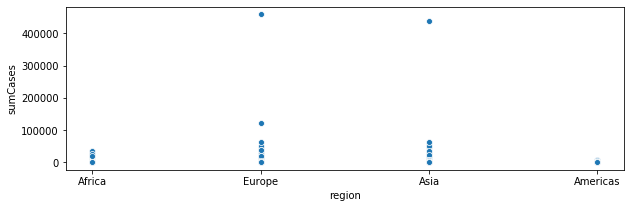

In [17]:

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['region'], y=outbreaks['sumCases'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs sumCases')
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['disease'], y=outbreaks['sumAtRisk'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs sumAtRisk')
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['localityQuality'], y=outbreaks['sumDeaths'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs sumDeaths')
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['humansAffected'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs humansAffected')
plt.show()

## Diseases

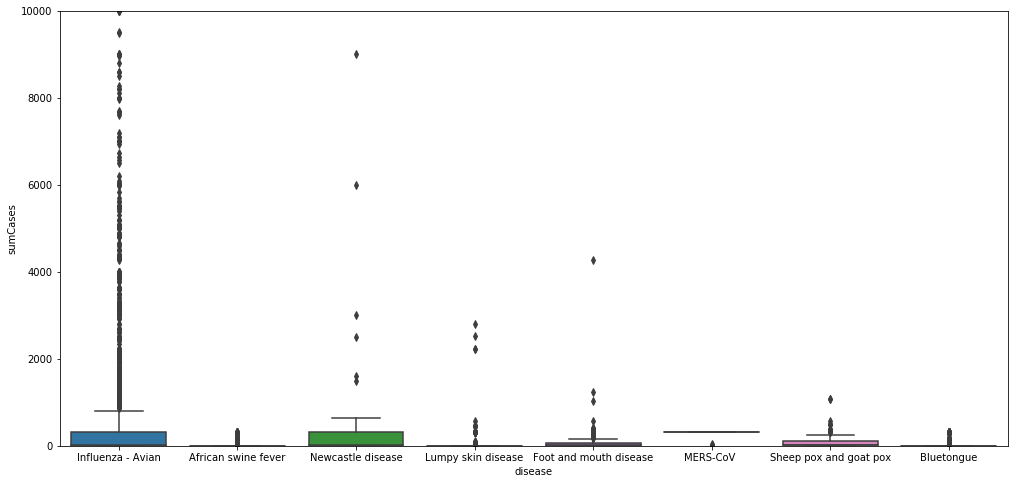

,Id,source,latitude,longitude,region,country,localityQuality,observationDate,reportingDate,status,disease,serotypes,speciesDescription,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansAge,humansAffected,humansDeaths,differenceInDays,observationYear,observationMonth,observationDay,observationFirstHalfMonth,observationSecondHalfMonth,EC,FAO Field Officer,FAO officer,FAO-Report,International reference laboratory,"National Institute for Communicable Diseases, NICD",National authorities,OIE,Other,Publications,WHO,sequence only,Africa,Americas,Asia,Europe,Albania,Algeria,Angola,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belgium,Belize,Benin,Bhutan,Bosnia and Herzegovina,Botswana,Brazil,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Chile,China,Colombia,Croatia,Cyprus,Czech Republic,CÃ´te d'Ivoire,Democratic Republic of the Congo,Denmark,Ecuador,Egypt,El Salvador,Estonia,Finland,France,French Guiana,Gambia,Gaza Strip,Georgia,Germany,Ghana,Greece,Guinea-Bissau,"Hong Kong, SAR",Hungary,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Libya,Lithuania,Luxembourg,Macau,Malawi,Malaysia,Maldives,Mali,Mauritania,Mauritius,Mexico,"Moldova, Republic of",Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Netherlands,Niger,Nigeria,Oman,Panama,Philippines,Poland,Portugal,Qatar,Republic of Korea,Romania,Russian Federation,Saudi Arabia,Senegal,Serbia,Slovakia,Slovenia,South Africa,Spain,Swaziland,Sweden,Switzerland,Syrian Arab Republic,Taiwan (Province of China),Thailand,The former Yugoslav Republic of Macedonia,Togo,Tunisia,Turkey,U.K. of Great Britain and Northern Ireland,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,United States of America,Uruguay,Viet Nam,West Bank,Zambia,Zimbabwe,Centroid Admin1,Centroid Admin2,Centroid Locality,Exact,Unknown,Confirmed,Denied,African horse sickness,African swine fever,Anthrax,Bluetongue,Bovine spongiform encephalopathy,Bovine tuberculosis,Brucellosis (Brucella abortus),Brucellosis (Brucella melitensis),Brucellosis (Brucella suis),Classical swine fever,Contagious bovine pleuropneumonia,Equine infectious anaemia,Foot and mouth disease,Glanders,Influenza - Avian,Influenza - Equine,Influenza - Swine,Lumpy skin disease,MERS-CoV,Newcastle disease,Peste des petits ruminants,Porcine reproductive and respiratory syndrome,Rabies,Rift Valley fever,Sheep pox and goat pox,West Nile Fever,1,13,14,18,19,22,3,4,7,8,A,APMV-I,Asia 1,H1N2,H3N8,H5 HPAI,H5 LPAI,H5N1 HPAI,"H5N1 HPAI, H5N2 HPAI","H5N1 HPAI, H5N6 HPAI",H5N1 LPAI,H5N2 HPAI,"H5N2 HPAI, H5N1 HPAI","H5N2 HPAI, H5N6 HPAI",H5N2 LPAI,H5N3 HPAI,H5N3 LPAI,H5N5 HPAI,H5N6 HPAI,"H5N6 HPAI, H5N1 HPAI","H5N6 HPAI, H5N1 HPAI, H5N2 HPAI","H5N6 HPAI, H5N2 HPAI","H5N6 HPAI, H5N2 HPAI, H5N1 HPAI","H5N6 HPAI, H5N6 HPAI","H5N6 HPAI, H5N8 HPAI",H5N6 LPAI,H5N8 HPAI,"H5N8 HPAI, H5N1 HPAI, H5N6 HPAI","H5N8 HPAI, H5N2 HPAI",H5N8 LPAI,H5N9 HPAI,H5N9 LPAI,H7 LPAI,H7N1 HPAI,H7N2 LPAI,H7N3 HPAI,H7N3 LPAI,H7N6 LPAI,H7N7 HPAI,H7N7 LPAI,H7N8 LPAI,H7N9 HPAI,H7N9 LPAI,H9N2 LPAI,HPAI,Not Specified,Not specified,O,SAT2,SAT3,Uknown Serotypes,wild,undomestic,domestic,captive,unspecified,birds,mammals
0,230399,OIE,-27.900000,30.800000,Africa,South Africa,Exact,2017-08-17,2017-08-22,Confirmed,Influenza - Avian,H5N8 HPAI,"[domestic,, unspecified, bird]",248000.000000,12.0,12.0,50000.000000,0.000000,0.000000,1.0,1.0,5.0,2017,8,17,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
1,230381,OIE,54.837037,73.3541

In [111]:
top8_diseases.head()

plt.figure(figsize=(17,8))
box = sns.boxplot(y='sumCases', x='disease', data=top8_diseases)
box.set_ylim(0, 10000)
plt.show()

top8_diseases.head()

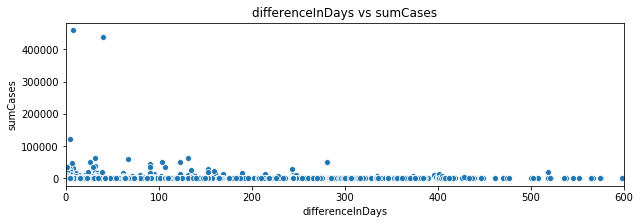

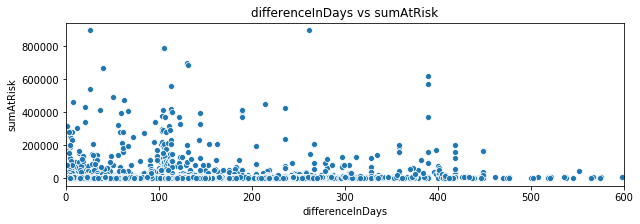

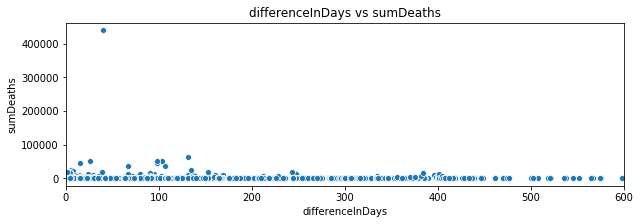

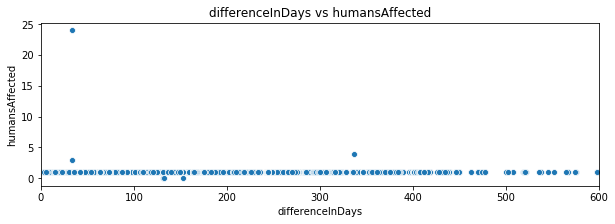

In [19]:

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumAtRisk'])
plt.title('differenceInDays vs sumAtRisk')
scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumDeaths'])
plt.title('differenceInDays vs sumDeaths')
scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['humansAffected'])
plt.title('differenceInDays vs humansAffected')
scatterplot.set_xlim(0, 600)
plt.show()

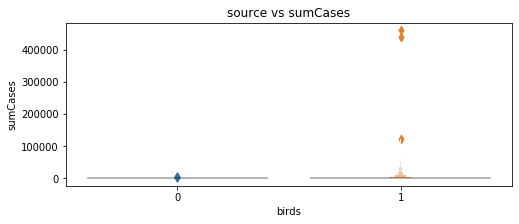

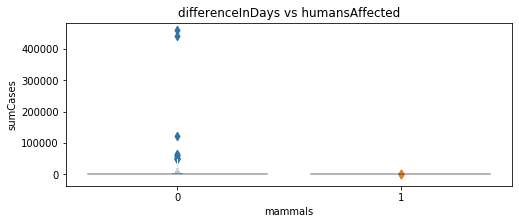

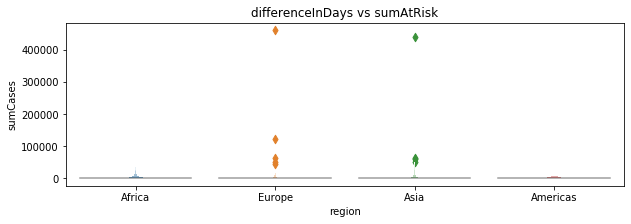

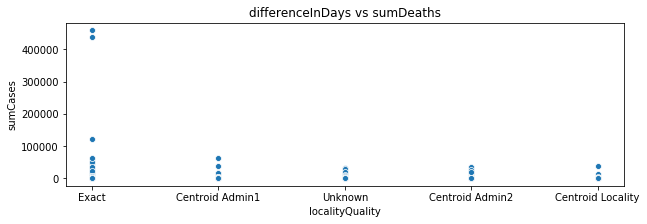

In [17]:
plt.figure(figsize=(8,3))
boxenplot = sns.boxenplot(x=outbreaks['birds'], y=outbreaks['sumCases'])
plt.title('source vs sumCases')
#scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(8,3))
boxenplot = sns.boxenplot(x=outbreaks['mammals'], y=outbreaks['sumCases'])
plt.title('differenceInDays vs humansAffected')
#scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
boxenplot = sns.boxenplot(x=outbreaks['region'], y=outbreaks['sumCases'])
plt.title('differenceInDays vs sumAtRisk')
#boxenplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['localityQuality'], y=outbreaks['sumCases'])
plt.title('differenceInDays vs sumDeaths')
#scatterplot.set_xlim(0, 600)
plt.show()


In [20]:
features_to_test = outbreaks[['sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered', 'humansAge',
                             'humansAffected', 'humansDeaths', 'differenceInDays']]
for feat in features_to_test:
    jb_stats = stats.jarque_bera(outbreaks[feat])
    norm_stats = stats.normaltest(outbreaks[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on sumAtRisk:
Jarque-Bera test statistics for sumAtRisk is 31000614.79592809 and p value is 0.0
Normality test statistics for sumAtRisk is 23142.035622884763 and p value is 0.0

Testing for normality on sumCases:
Jarque-Bera test statistics for sumCases is 11137004109.799223 and p value is 0.0
Normality test statistics for sumCases is 43488.628730504606 and p value is 0.0

Testing for normality on sumDeaths:
Jarque-Bera test statistics for sumDeaths is 49823527573.628174 and p value is 0.0
Normality test statistics for sumDeaths is 49389.573754484634 and p value is 0.0

Testing for normality on sumDestroyed:
Jarque-Bera test statistics for sumDestroyed is 91313545.70287018 and p value is 0.0
Normality test statistics for sumDestroyed is 26247.14098262732 and p value is 0.0

Testing for normality on sumSlaughtered:
Jarque-Bera test statistics for sumSlaughtered is 8674319210.08637 and p value is 0.0
Normality test statistics for sumSlaughtered is 42615.69380389212 

In [80]:
outbreaks['norm_differenceInDays'] = normalize(np.array(np.log(outbreaks['differenceInDays'])).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_sumAtRisk'] = normalize(np.array(np.sqrt(outbreaks['sumAtRisk'])).reshape(-1, 1))
outbreaks['norm_sumCases'] = normalize(np.array(np.sqrt(outbreaks['sumCases'])).reshape(1,-1).reshape(-1,1))
outbreaks['norm_sumDeaths'] = normalize(np.array(np.sqrt(outbreaks['sumDeaths'])).reshape(1,-1).reshape(-1,1))
outbreaks['norm_sumDestroyed'] = normalize(np.array(np.log(outbreaks['sumDestroyed'] + 1)).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_sumSlaughtered'] = normalize(np.array(np.log(outbreaks['sumSlaughtered'] + 1)).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_humansAge'] = normalize(np.array(np.sqrt(outbreaks['humansAge'])).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_humansAffected'] = normalize(np.array(np.sqrt(outbreaks['humansAffected'])).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_humansDeaths'] = normalize(np.array(np.sqrt(outbreaks['humansDeaths'])).reshape(1,-1)).reshape(-1,1)

norm_features_to_test = ['norm_differenceInDays', 'norm_sumAtRisk', 'norm_sumCases', 'norm_sumDestroyed', 
                         'norm_sumSlaughtered', 'norm_humansAge', 'norm_humansAffected', 'norm_humansDeaths']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in norm_features_to_test:
    jb_stats = stats.jarque_bera(outbreaks[feat])
    norm_stats = stats.normaltest(outbreaks[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_differenceInDays:
Jarque-Bera test statistics for norm_differenceInDays is 613.9940887824272 and p value is 0.0
Normality test statistics for norm_differenceInDays is 1760.3923896373988 and p value is 0.0

Testing for normality on norm_sumAtRisk:
Jarque-Bera test statistics for norm_sumAtRisk is 2046676.5838905706 and p value is 0.0
Normality test statistics for norm_sumAtRisk is 16853.327562212307 and p value is 0.0

Testing for normality on norm_sumCases:
Jarque-Bera test statistics for norm_sumCases is 93002.3029832742 and p value is 0.0
Normality test statistics for norm_sumCases is 9160.862934594179 and p value is 0.0

Testing for normality on norm_sumDestroyed:
Jarque-Bera test statistics for norm_sumDestroyed is 1823.6498306850474 and p value is 0.0
Normality test statistics for norm_sumDestroyed is 100714.73793381744 and p value is 0.0

Testing for normality on norm_sumSlaughtered:
Jarque-Bera test statistics for norm_sumSlaughtered is 2769.2126679

In [87]:
corr_mat = np.abs((outbreaks.corr().loc[:, ['norm_humansDeaths']])).sort_values(by='norm_humansDeaths', ascending=False)
corr_mat[:50]

,norm_humansDeaths
norm_humansDeaths,1.000000
humansDeaths,0.995235
MERS-CoV,0.175741
Saudi Arabia,0.169479
"H5N8 HPAI, H5N2 HPAI",0.168391
norm_humansAffected,0.130030
Portugal,0.118750
WHO,0.111296
Centroid Admin1,0.096415
Asia,0.085707


# Dimensionality Reduction

## PCA

In [81]:
# PCA with all variables, including humansDeaths
X_all = outbreaks.drop(columns=['disease', 'serotypes', 'speciesDescription', 'sumAtRisk', 'sumCases', 'sumDeaths', 
                            'sumDestroyed','sumSlaughtered', 'humansAge', 'humansAffected', 'humansDeaths', 
                            'differenceInDays', 'source', 'region', 'country', 'localityQuality', 'status', 
                            'observationDate', 'reportingDate']).sample(n=12000)


pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
print(pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80 = pca_80.fit_transform(X_all)
print(pca_80.explained_variance_ratio_)

[9.99959246e-01 3.45626357e-05]
[0.99995925]


Cluster Graph with PCA 


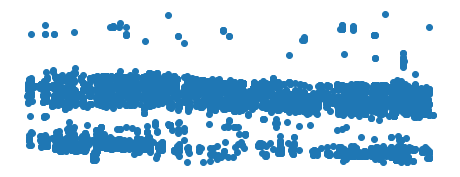

In [82]:
print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

First two PCA components:  [0.79101318 0.17491563]
PCA components for 80% of variance:  [0.79101318 0.17491563]
Cluster Graph with PCA 


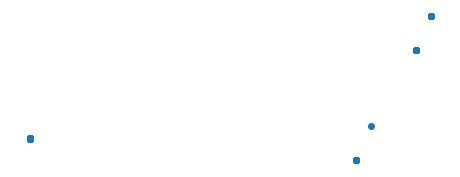

In [83]:
# PCA with floats, no humansDeaths
X_floats = outbreaks[['norm_sumAtRisk', 'norm_sumCases', 'norm_sumDeaths', 'norm_sumDestroyed','norm_sumSlaughtered', 
                      'norm_humansAge','norm_humansAffected', 'norm_differenceInDays']]

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_floats)
print('First two PCA components: ', pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80 = pca_80.fit_transform(X_floats)
print('PCA components for 80% of variance: ', pca_80.explained_variance_ratio_)


print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

First two PCA components:  [0.87935156 0.11164321]
PCA components for 80% of variance:  [0.87935156]
Cluster Graph with PCA 


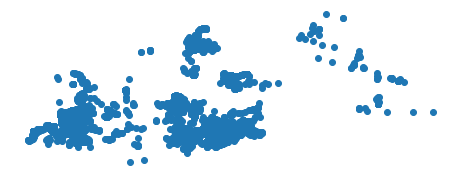

In [94]:
# PCA for features with greater than 0.01 absolute correlation with potential target

X_01 = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI', 'norm_humansAffected', 'Portugal', 'MERS-CoV ',
                      'WHO', 'Centroid Admin1', 'Asia', 'norm_sumSlaughtered', 'OIE', 'Other', 'National authorities',
                      'Europe', 'norm_sumDestroyed', 'Jordan', 'latitude', 'Exact', 'Centroid Locality', 
                      'observationYear', 'longitude', 'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8', 'norm_humansAge', 
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer', 'norm_sumCases', 'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea']]

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01)
print('First two PCA components: ', pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80 = pca_80.fit_transform(X_01)
print('PCA components for 80% of variance: ', pca_80.explained_variance_ratio_)


print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

First two PCA components:  [0.77978289 0.04593126]
PCA components for 80% of variance:  [0.77978289 0.04593126]
Cluster Graph with PCA 


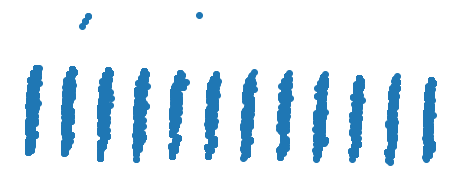

In [131]:
# PCA for features with greater than 0.01 absolute correlation with norm_humanDeaths

X_01hd = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI',  'Portugal',
                      'WHO', 'Centroid Admin1', 'Asia',  'OIE', 'Other', 'National authorities',
                      'Europe',  'Jordan', 'Exact', 'Centroid Locality', 
                      'observationYear',  'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8',  
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer',  'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea',
                     'norm_sumAtRisk', 'norm_sumCases', 'norm_sumDeaths', 
                      'norm_sumDestroyed','norm_sumSlaughtered', 'norm_humansAge',
                   'norm_humansAffected', 'norm_differenceInDays', 'norm_humansDeaths']]

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01hd)
print('First two PCA components: ', pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80 = pca_80.fit_transform(X_01hd)
print('PCA components for 80% of variance: ', pca_80.explained_variance_ratio_)


print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## t-SNE

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 12000 samples in 1.358s...
[t-SNE] Computed neighbors for 12000 samples in 1.337s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 6.254951
[t-SNE] KL divergence

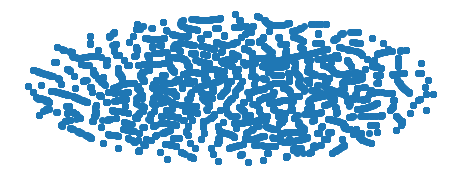

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 12000 samples in 1.381s...
[t-SNE] Computed neighbors for 12000 samples in 1.426s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 11.864904
[t-SNE] KL divergenc

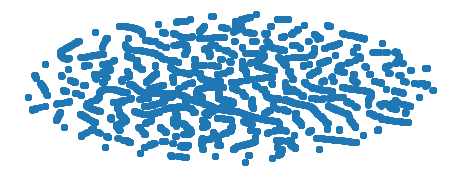

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 1.397s...
[t-SNE] Computed neighbors for 12000 samples in 1.794s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 16.540526
[t-SNE] KL divergenc

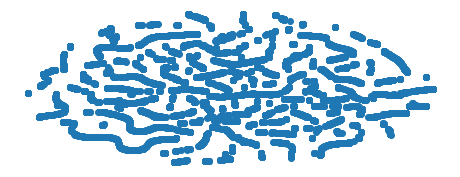

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 1.394s...
[t-SNE] Computed neighbors for 12000 samples in 1.941s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 20.066706
[t-SNE] KL divergen

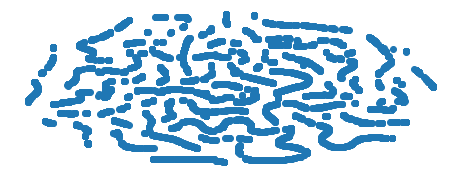

In [26]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X_all)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)
    plt.figure(figsize=(8,3))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.320s...
[t-SNE] Computed neighbors for 12702 samples in 2.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

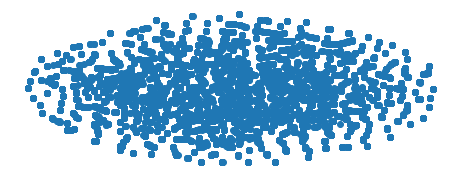

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.423s...
[t-SNE] Computed neighbors for 12702 samples in 3.543s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

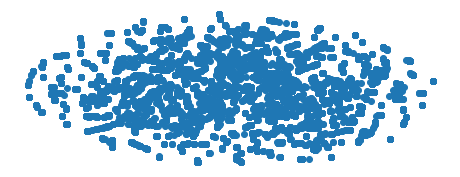

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.365s...
[t-SNE] Computed neighbors for 12702 samples in 4.345s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

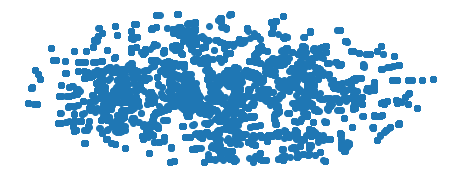

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.320s...
[t-SNE] Computed neighbors for 12702 samples in 4.699s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sa

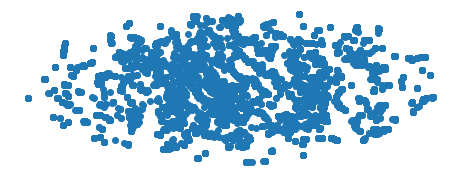

In [160]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X_01hd)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)
    plt.figure(figsize=(8,3))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

## UMAP

In [60]:
# UMAP with all features
for n_neighbors in [50, 100, 250]:
    for min_dist in [0.1, 0.5, 0.75, 1]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').fit_transform(X)
        print('UMAP with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

NameError: name 'umap' is not defined

In [21]:
lle_results = LocallyLinearEmbedding(n_components=2, 
                    n_neighbors=100,
                    eigen_solver='dense').fit_transform(X_01hd)
print('LLE with ', n_neighbors, 'neighbors and two components.')
plt.figure(figsize=(10,5))
plt.scatter(lle_results[:, 0], lle_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
print('\n')

NameError: name 'X_01' is not defined

In [ ]:
# UMAP with float features
for n_neighbors in [50, 100, 250]:
    for min_dist in [ 0.01, 0.1, 0.5, 0.75, 1]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').fit_transform(X_floats)
        print('UMAP with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

# Clustering

I'll use K-Means, DBSCAN, Agglomerative, and GMM clustering techniques. 

## K-Means with PCA

70.7 ms ± 8.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
119 ms ± 6.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
178 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
227 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
237 ms ± 8.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
415 ms ± 70.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
526 ms ± 97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
365 ms ± 36.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
505 ms ± 64.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
640 ms ± 38.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
704 ms ± 42.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


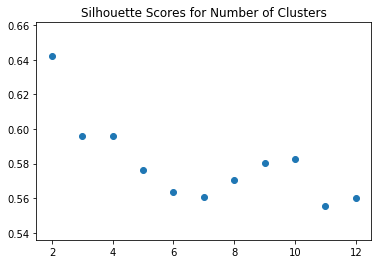

Best Silhouette score is 0.64209784543382 with 2 clusters. 
Best Davies Bouldin score:  0.47462748859241316
81 ms ± 5.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


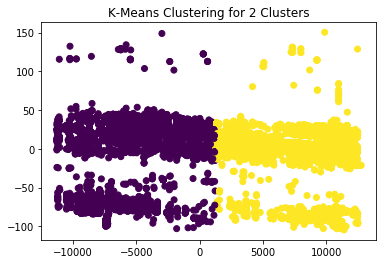

In [130]:

# K-means with PCA with all variables, including humansDeaths
X_all = outbreaks.drop(columns=['disease', 'serotypes', 'speciesDescription', 'sumAtRisk', 'sumCases', 'sumDeaths', 
                            'sumDestroyed','sumSlaughtered', 'humansAge', 'humansAffected', 'humansDeaths', 
                            'differenceInDays', 'source', 'region', 'country', 'localityQuality', 'status', 
                            'observationDate', 'reportingDate'])


pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
silhouettes_kpca = []
silhouettes_kpca_dict = {} # silhoutte scores are keys, clusters are values
dbs_kpca = []

# looping through cluster numbers to find the best cluster
for cluster in clusters:
    
    labels = KMeans(n_clusters=cluster, random_state=123).fit_predict(pca_components)
    kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
    %timeit kmeans_cluster.fit(pca_components)
    y_pred = kmeans_cluster.predict(pca_components)
    silhouette = metrics.silhouette_score(pca_components, labels, metric='euclidean', sample_size=5000)
    silhouettes_kpca.append(silhouette)
    silhouettes_kpca_dict[silhouette] = cluster
    db = metrics.davies_bouldin_score(pca_components, labels)
    dbs_kpca.append(db)

# plotting the silhouette scores
plt.title('Silhouette Scores for Number of Clusters')  
plt.scatter(list(silhouettes_kpca_dict.values()), list(silhouettes_kpca_dict.keys()))
plt.show()


print('Best Silhouette score is {} with {} clusters. '.format(max(silhouettes_kpca_dict.keys()), silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]))
print('Best Davies Bouldin score: ', min(dbs_kpca))

# plotting the clusters with the best silhouette score
best_cluster = silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]
labels = KMeans(n_clusters=best_cluster, random_state=123).fit_predict(pca_components)
kmeans_cluster = KMeans(n_clusters=best_cluster, random_state=123)
%timeit kmeans_cluster.fit(pca_components)
y_pred = kmeans_cluster.predict(pca_components)

plt.title('K-Means Clustering for {} Clusters'.format(silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]))
plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
plt.show()

49 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
79 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
90.7 ms ± 7.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
162 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
322 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
266 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
291 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
439 ms ± 50.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
421 ms ± 47.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
462 ms ± 67.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
530 ms ± 41.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


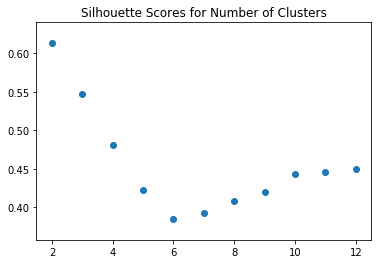

Best Silhouette score is 0.6136257835051623 with 2 clusters. 
Best Davies Bouldin score:  0.5392181086251422
54.3 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


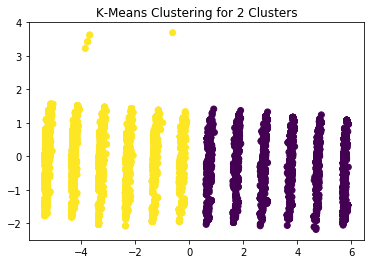

In [132]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01hd)
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
silhouettes_kpca = []
silhouettes_kpca_dict = {} # silhoutte scores are keys, clusters are values
dbs_kpca = []

# looping through cluster numbers to find the best cluster
for cluster in clusters:
    
    labels = KMeans(n_clusters=cluster, random_state=123).fit_predict(pca_components)
    kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
    %timeit kmeans_cluster.fit(pca_components)
    y_pred = kmeans_cluster.predict(pca_components)
    silhouette = metrics.silhouette_score(pca_components, labels, metric='euclidean', sample_size=5000)
    silhouettes_kpca.append(silhouette)
    silhouettes_kpca_dict[silhouette] = cluster
    db = metrics.davies_bouldin_score(pca_components, labels)
    dbs_kpca.append(db)

# plotting the silhouette scores
plt.title('Silhouette Scores for Number of Clusters')  
plt.scatter(list(silhouettes_kpca_dict.values()), list(silhouettes_kpca_dict.keys()))
plt.show()


print('Best Silhouette score is {} with {} clusters. '.format(max(silhouettes_kpca_dict.keys()), silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]))
print('Best Davies Bouldin score: ', min(dbs_kpca))

# plotting the clusters with the best silhouette score
best_cluster = silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]
labels = KMeans(n_clusters=best_cluster, random_state=123).fit_predict(pca_components)
kmeans_cluster = KMeans(n_clusters=best_cluster, random_state=123)
%timeit kmeans_cluster.fit(pca_components)
y_pred = kmeans_cluster.predict(pca_components)

plt.title('K-Means Clustering for {} Clusters'.format(silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]))
plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
plt.show()

## Agglomerative with PCA

In [155]:
pca_components = pca.fit_transform(X_01hd.sample(3500))
clusters = agg_cluster.fit_predict(pca_components)
silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
print(silhouette)

0.6057808344339201


In [159]:
# With PCA components from features with greater than 0.01 correlation
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01hd.sample(3500))
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
silhouettes_aggpca = []
silhouettes_aggpca_dict = {} # silhoutte scores are keys, clusters are values
dbs_aggpca = []
linkage_types = ['ward', 'complete', 'average']


# looping through cluster numbers to find the best cluster
for link in linkage_types:
    for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        clusters = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
        silhouettes_aggpca.append(silhouette)
        silhouettes_aggpca_dict[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, clusters)
        dbs_aggpca.append(db)

# plotting the silhouette scores
plt.title('Silhouette Scores for Number of Clusters')  
plt.scatter(list(silhouettes_aggpca_dict.values()), list(silhouettes_aggpca_dict.keys()))
plt.show()


print('Best Silhouette score is {} with {} clusters. '.format(max(silhouettes_aggpca_dict.keys()), silhouettes_aggpca_dict[max(silhouettes_kpca_dict.keys())]))
print('Best Davies Bouldin score: ', min(dbs_aggpca))

# plotting the clusters with the best silhouette score
best_cluster = silhouettes_aggpca_dict[max(silhouettes_aggpca_dict.keys())]
agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity='euclidean',
                                      n_clusters=cluster)
clusters = agg_cluster.fit_predict(pca_components)

plt.title('Agglomerative Clustering for {} Clusters'.format(silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]))
plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
plt.show()


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [161]:
pd.Series(clusters).value_counts()

0    3500
dtype: int64

The Silhoutte score with average linkage and 4 clusters: 0.7621097466434971


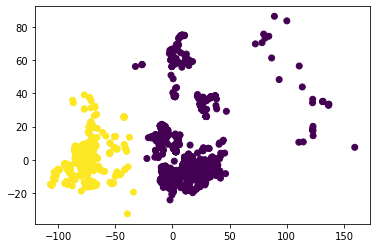

{0: 3246, 1: 754}
norm_sumSlaughtered:  agg_pca_clusters
0    0.003453
1    0.009538
Name: norm_sumSlaughtered, dtype: float64
norm_sumDestroyed:  agg_pca_clusters
0    0.003948
1    0.013011
Name: norm_sumDestroyed, dtype: float64
norm_sumCases:  agg_pca_clusters
0    0.937153
1    0.911141
Name: norm_sumCases, dtype: float64


,Saudi Arabia,H5N8 HPAI,H5N2 HPAI,norm_humansAffected,Portugal,MERS-CoV,WHO,Centroid Admin1,Asia,norm_sumSlaughtered,OIE,Other,National authorities,Europe,norm_sumDestroyed,Jordan,latitude,Exact,Centroid Locality,observationYear,longitude,mammals,Bluetongue,birds,H7N9 LPAI,African swine fever,France,China,H5N8 HPAI,wild,8,norm_humansAge,observationMonth,Lumpy skin disease,Taiwan (Province of China),Malaysia,Rabies,Africa,unspecified,4,FAO Field Officer,norm_sumCases,H5N1 HPAI,Albania,Latvia,Serbia,Estonia,Russian Federation,Republic of Korea,agg_pca_clusters
7441,0,1,0,0.008864,0,0,0,0,0,0.000000,1,0,0,1,0.000000,0,46.850000,1,0,2016,6.840000,0,0,1,0,0,0,0,1,1,0,0.008884,11,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0
2753,0,1,0,0.008864,0,0,0,0,0,0.000000,1,0,0,1,0.003886,0,49.850500,1,0,2017,18.533900,0,0,1,0,0,0,0,1,0,0,0.008884,2,0,0,0,0,0,1,0,0,1.0,0,0,0,0,0,0,0,0
2232,0,0,0,0.008864,0,0,0,0,0,0.000000,1,0,0,1,0.000000,0,46.481424,1,0,2017,4.740233,0,1,0,0,0,1,0,0,0,1,0.008884,3,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0
1765,0,1,0,0.008864,0,0,0,0,0,0.000000,1,0,0,1,0.011359,0,43.371400,1,0,2017,-1.000000,0,0,1,0,0,1,0,1,0,0,0.008884,3,0,0,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0
5604,0,0,0,0.008864,0,0,0,0,1,0.017024,0,0,1,0,0.014562,0,31.304000,1,0,2016,120.586000,0,0,0,1,0,0,1,0,0,0,0.008884,12,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,1
1449,0,0,0,0.008864,0,0,0,0,0,0.000000,1,0,0,1,0.000000,0,55.714700,1,0,2017,26.141900,1,0,0,0,1,0,0,0,1,0,0.008884,3,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0
9485,0,0,0,0.008864,0,0,0,0,0,0.000000,1,0,0,1,0.000000,0,43.797400,0,0,2016,19.299600,1,1,0,0,0,0,0,0,0,0,0.008884,9,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0
7517,0,0,0,0.008864,0,0,0,0,0,0.000000,1,0,0,1,0.000000,0,46.434464,0,0,2016,5.478941,0,1,0,0,0,1,0,0,0,1,0.008884,11,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0
6602,0,0,0,0.008864,0,0,0,0,0,0.000000,1,0,0,1,0.000000,0,45.854393,1,0,2016,3.784896,0,1,0,0,0,1,0,0,0,1,0.008884,11,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0
13269,0,0,0,0.008864,0,0,0,0,0,0.000000,1,0,0,1,0.000000,0,58.269444,1,0,2016,26.258889,1,0,0,0,1,0,0,0,1,0,0.008884,2,0,0,0,0,0,0,0,0,1.0,0,0,0,0,1,0,0,0


In [105]:
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)
silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
print('The Silhoutte score with', link,'linkage and', cluster, 'clusters: {}'.format(silhouette))
plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
plt.show()

unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))
X_01_agg['agg_pca_clusters'] = clusters

print('norm_sumSlaughtered: ', X_01_agg.groupby('agg_pca_clusters')['norm_sumSlaughtered'].mean())
print('norm_sumDestroyed: ', X_01_agg.groupby('agg_pca_clusters')['norm_sumDestroyed'].mean())
print('norm_sumCases: ', X_01_agg.groupby('agg_pca_clusters')['norm_sumCases'].mean())

X_01_agg.head(20)

In [50]:
print('norm_sumSlaughtered: ', X_01_agg.groupby('agg_pca_clusters')['norm_sumSlaughtered'].mean())
print('norm_sumDestroyed: ', X_01_agg.groupby('agg_pca_clusters')['norm_sumDestroyed'].mean())
print('norm_sumCases: ', X_01_agg.groupby('agg_pca_clusters')['norm_sumCases'].mean())
# print('norm_sumSlaughtered: ', X_01_agg.groupby('agg_pca_clusters')['norm_sumSlaughtered'].mean)

norm_sumSlaughtered:  agg_pca_clusters
0    0.003389
1    0.009963
Name: norm_sumSlaughtered, dtype: float64
norm_sumDestroyed:  agg_pca_clusters
0    0.003918
1    0.012995
Name: norm_sumDestroyed, dtype: float64
norm_sumCases:  agg_pca_clusters
0    0.947026
1    0.926166
Name: norm_sumCases, dtype: float64


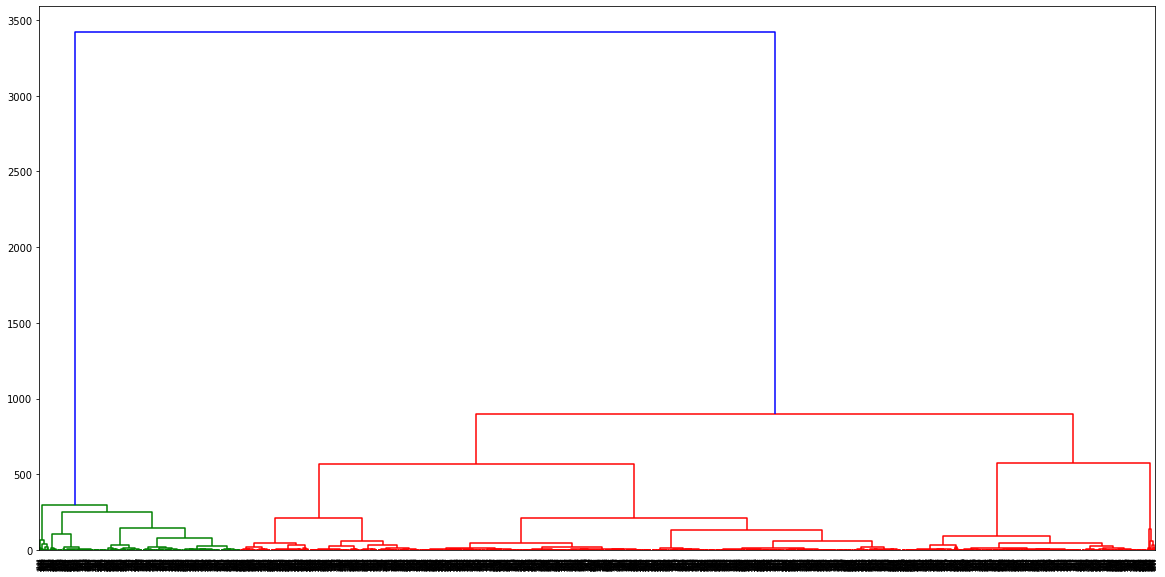

In [110]:
X_01_agg = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI', 'Portugal',
                      'WHO', 'Centroid Admin1', 'Asia',  'OIE', 'Other', 'National authorities',
                      'Europe', 'Jordan', 'latitude', 'Exact', 'Centroid Locality', 
                      'observationYear',  'longitude', 'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8',  
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer', 'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea', 'norm_sumAtRisk', 
                      'norm_sumCases', 'norm_sumDeaths', 'norm_sumDestroyed','norm_sumSlaughtered', 
                      'norm_humansAge','norm_humansAffected', 'norm_differenceInDays']].sample(n=4000)
pca = PCA(n_components=1)
pca_components = pca.fit_transform(X_01_agg)
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

plt.figure(figsize=(20,10))
dendrogram(lnkg(pca_components, method='ward'))
plt.show()

In [51]:
pca_components[0]

array([34.08725055])

The Silhoutte score with ward linkage and 2 clusters: 0.7684065673167959
The Davies Bouldin score with ward linkage and 2 clusters: 0.28679159609737437


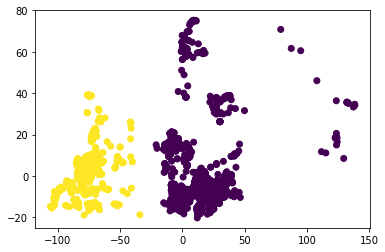



The Silhoutte score with ward linkage and 3 clusters: 0.6492824821336882
The Davies Bouldin score with ward linkage and 3 clusters: 0.5499478384795946


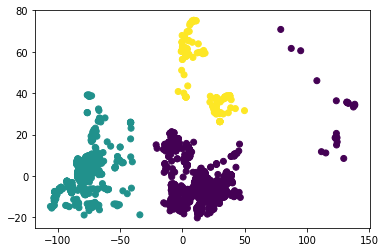



The Silhoutte score with ward linkage and 4 clusters: 0.5189059332243267
The Davies Bouldin score with ward linkage and 4 clusters: 0.6192508920854649


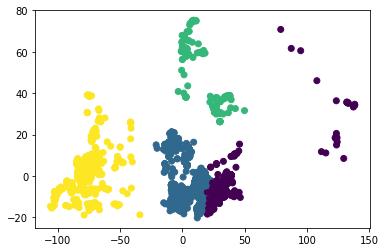



The Silhoutte score with complete linkage and 2 clusters: 0.7684065673167959
The Davies Bouldin score with complete linkage and 2 clusters: 0.28679159609737437


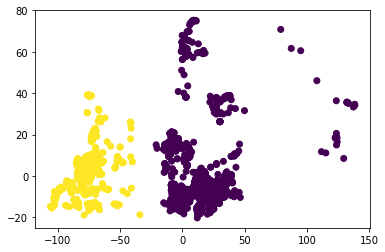



The Silhoutte score with complete linkage and 3 clusters: 0.7652713543160644
The Davies Bouldin score with complete linkage and 3 clusters: 0.3037257202115319


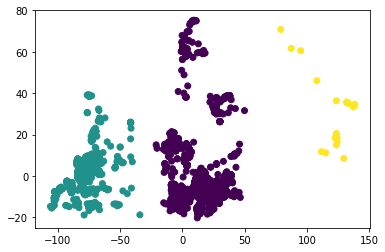



The Silhoutte score with complete linkage and 4 clusters: 0.6649080538428584
The Davies Bouldin score with complete linkage and 4 clusters: 0.4919765284102729


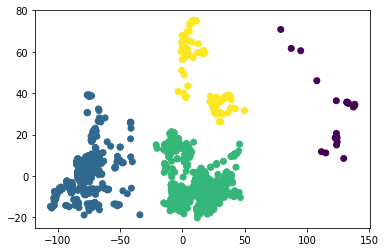



The Silhoutte score with average linkage and 2 clusters: 0.644084372021003
The Davies Bouldin score with average linkage and 2 clusters: 0.4258475534579252


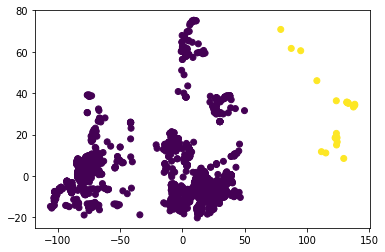



The Silhoutte score with average linkage and 3 clusters: 0.7652713543160644
The Davies Bouldin score with average linkage and 3 clusters: 0.3037257202115318


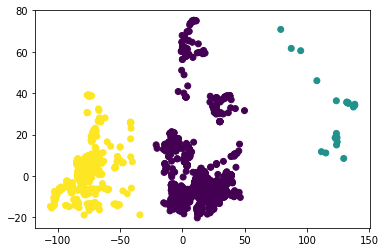



The Silhoutte score with average linkage and 4 clusters: 0.6649080538428584
The Davies Bouldin score with average linkage and 4 clusters: 0.49197652841027284


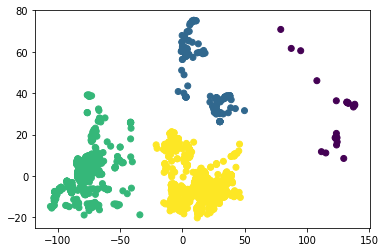



The greatest silhouette score is 0.7684065673167959.


In [59]:
# With PCA components from features with greater than 0.01 correlation
X_01_agg = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI', 'Portugal',
                      'WHO', 'Centroid Admin1', 'Asia',  'OIE', 'Other', 'National authorities',
                      'Europe', 'Jordan', 'latitude', 'Exact', 'Centroid Locality', 
                      'observationYear', 'Uknown', 'longitude', 'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8',  
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer', 'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea', 'norm_sumAtRisk', 
                      'norm_sumCases', 'norm_sumDeaths', 'norm_sumDestroyed','norm_sumSlaughtered', 
                      'norm_humansAge','norm_humansAffected', 'norm_differenceInDays']].sample(n=4000)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01_agg)
silhouettes_aggpca = []
db_aggpca = []

linkage_types = ['ward', 'complete', 'average']
numbers = [2, 3, 4]
silhouettes = []
for link in linkage_types:
    for cluster in numbers:
        agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        clusters = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
        db = metrics.davies_bouldin_score(pca_components, clusters)
        print('The Silhoutte score with', link,'linkage and', cluster, 'clusters: {}'.format(silhouette))
        print('The Davies Bouldin score with', link,'linkage and', cluster, 'clusters: {}'.format(db))
        plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
        plt.show()
        silhouettes_aggpca.append(metrics.silhouette_score(pca_components, clusters, metric='euclidean'))
        db_aggpca.append(db)
        print('\n')
        
print('The greatest silhouette score is {}.'.format(max(silhouettes_aggpca)))

In [53]:
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))
X_01_agg['2agg_pca_clusters'] = clusters

print('norm_sumSlaughtered: ', X_01_agg.groupby('2agg_pca_clusters')['norm_sumSlaughtered'].mean())
print('norm_sumDestroyed: ', X_01_agg.groupby('2agg_pca_clusters')['norm_sumDestroyed'].mean())
print('norm_sumCases: ', X_01_agg.groupby('2agg_pca_clusters')['norm_sumCases'].mean())
print('norm_sumDeaths: ', X_01_agg.groupby('2agg_pca_clusters')['norm_sumDeaths'].mean())
print('norm_humansAffected: ', X_01_agg.groupby('2agg_pca_clusters')['norm_humansAffected'].mean())

X_01_agg.head(20)

{0: 3237, 1: 763}
norm_sumSlaughtered:  2agg_pca_clusters
0    0.003461
1    0.010107
Name: norm_sumSlaughtered, dtype: float64
norm_sumDestroyed:  2agg_pca_clusters
0    0.003938
1    0.013061
Name: norm_sumDestroyed, dtype: float64
norm_sumCases:  2agg_pca_clusters
0    0.943466
1    0.927916
Name: norm_sumCases, dtype: float64
norm_sumDeaths:  2agg_pca_clusters
0    0.492431
1    0.858453
Name: norm_sumDeaths, dtype: float64
norm_humansAffected:  2agg_pca_clusters
0    0.008864
1    0.008876
Name: norm_humansAffected, dtype: float64


,Saudi Arabia,H5N8 HPAI,H5N2 HPAI,Portugal,WHO,Centroid Admin1,Asia,OIE,Other,National authorities,Europe,Jordan,latitude,Exact,Centroid Locality,observationYear,Uknown,longitude,mammals,Bluetongue,birds,H7N9 LPAI,African swine fever,France,China,H5N8 HPAI,wild,8,observationMonth,Lumpy skin disease,Taiwan (Province of China),Malaysia,Rabies,Africa,unspecified,4,FAO Field Officer,H5N1 HPAI,Albania,Latvia,Serbia,Estonia,Russian Federation,Republic of Korea,norm_sumAtRisk,norm_sumCases,norm_sumDeaths,norm_sumDestroyed,norm_sumSlaughtered,norm_humansAge,norm_humansAffected,norm_differenceInDays,2agg_pca_clusters
7756,0,0,0,0,0,0,0,1,0,0,1,0,43.688870,1,0,2016,0,19.885310,1,1,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.012938,0
16209,0,0,0,0,0,0,0,1,0,0,1,0,56.828600,1,0,2015,1,25.980000,1,0,0,0,1,0,0,0,1,0,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,1.0,0.0,0.000000,0.002556,0.008884,0.008864,0.003753,0
543,0,0,0,0,0,1,0,0,0,1,1,0,40.355140,0,0,2017,1,19.626310,0,0,0,0,0,0,0,0,0,0,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,1.0,0.0,0.014562,0.017024,0.008884,0.008864,0.001616,0
7864,0,0,0,0,0,0,0,1,0,0,1,0,46.894474,1,0,2016,0,5.093447,0,1,0,0,0,1,0,0,0,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.011220,0
9898,0,0,0,0,0,0,0,1,0,0,1,0,45.612420,1,0,2016,0,3.682880,0,1,0,0,0,1,0,0,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.005980,0
525,0,0,0,0,0,0,1,0,0,1,0,0,23.982560,0,0,2017,0,106.707275,0,0,0,1,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.014562,0.017024,0.015661,0.008864,0.008152,1
14178,0,0,0,0,0,0,0,1,0,0,0,0,11.891864,1,0,2016,0,8.141939,0,0,1,0,0,0,0,0,1,0,2,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1.0,1.0,1.0,0.012000,0.000000,0.008884,0.008864,0.009546,0
16480,0,0,0,0,0,0,0,1,0,0,0,0,-19.762350,1,0,2015,0,29.657160,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.010851,0
2741,0,1,0,0,0,0,0,1,0,0,1,0,43.672779,1,0,2017,0,-0.989154,0,0,1,0,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.008884,0.008864,0.005591,0
16485,0,0,0,0,0,0,0,1,0,0,1,0,56.953300,1,0,2015,1,25.981900,1,0,0,0,1,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,1.0,1.0,0.000000,0.000000,0.008884,0.008864,0.012511,0


The Silhoutte score with average linkage and 4 clusters: 0.6322573657405146


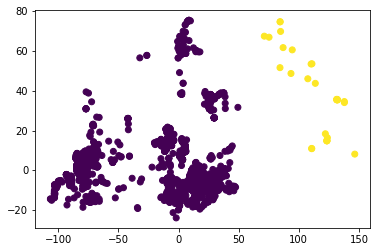



{0: 3969, 1: 31}
norm_sumSlaughtered:  agg_pca_complete_clusters
0    0.004740
1    0.003295
Name: norm_sumSlaughtered, dtype: float64
norm_sumDestroyed:  agg_pca_complete_clusters
0    0.005672
1    0.006450
Name: norm_sumDestroyed, dtype: float64
norm_sumCases:  agg_pca_complete_clusters
0    0.941547
1    0.806452
Name: norm_sumCases, dtype: float64
norm_sumDeaths:  agg_pca_complete_clusters
0    0.562862
1    0.483871
Name: norm_sumDeaths, dtype: float64
norm_humansAffected:  agg_pca_complete_clusters
0    0.008866
1    0.008864
Name: norm_humansAffected, dtype: float64


,Saudi Arabia,H5N8 HPAI,H5N2 HPAI,Portugal,WHO,Centroid Admin1,Asia,OIE,Other,National authorities,Europe,Jordan,latitude,Exact,Centroid Locality,observationYear,Uknown,longitude,mammals,Bluetongue,birds,H7N9 LPAI,African swine fever,France,China,H5N8 HPAI,wild,8,observationMonth,Lumpy skin disease,Taiwan (Province of China),Malaysia,Rabies,Africa,unspecified,4,FAO Field Officer,H5N1 HPAI,Albania,Latvia,Serbia,Estonia,Russian Federation,Republic of Korea,norm_sumAtRisk,norm_sumCases,norm_sumDeaths,norm_sumDestroyed,norm_sumSlaughtered,norm_humansAge,norm_humansAffected,norm_differenceInDays,2agg_pca_clusters,agg_pca_complete_clusters
7756,0,0,0,0,0,0,0,1,0,0,1,0,43.688870,1,0,2016,0,19.885310,1,1,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.012938,0,0
16209,0,0,0,0,0,0,0,1,0,0,1,0,56.828600,1,0,2015,1,25.980000,1,0,0,0,1,0,0,0,1,0,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,1.0,0.0,0.000000,0.002556,0.008884,0.008864,0.003753,0,0
543,0,0,0,0,0,1,0,0,0,1,1,0,40.355140,0,0,2017,1,19.626310,0,0,0,0,0,0,0,0,0,0,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,1.0,0.0,0.014562,0.017024,0.008884,0.008864,0.001616,0,0
7864,0,0,0,0,0,0,0,1,0,0,1,0,46.894474,1,0,2016,0,5.093447,0,1,0,0,0,1,0,0,0,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.011220,0,0
9898,0,0,0,0,0,0,0,1,0,0,1,0,45.612420,1,0,2016,0,3.682880,0,1,0,0,0,1,0,0,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.005980,0,0
525,0,0,0,0,0,0,1,0,0,1,0,0,23.982560,0,0,2017,0,106.707275,0,0,0,1,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.014562,0.017024,0.015661,0.008864,0.008152,1,0
14178,0,0,0,0,0,0,0,1,0,0,0,0,11.891864,1,0,2016,0,8.141939,0,0,1,0,0,0,0,0,1,0,2,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1.0,1.0,1.0,0.012000,0.000000,0.008884,0.008864,0.009546,0,0
16480,0,0,0,0,0,0,0,1,0,0,0,0,-19.762350,1,0,2015,0,29.657160,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.010851,0,0
2741,0,1,0,0,0,0,0,1,0,0,1,0,43.672779,1,0,2017,0,-0.989154,0,0,1,0,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.008884,0.008864,0.005591,0,0
16485,0,0,0,0,0,0,0,1,0,0,1,0,56.953300,1,0,2015,1,25.981900,1,0,0,0,1,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,1.0,1.0,0.000000,0.000000,0.008884,0.008864,0.012511,0,0


In [54]:
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
print('The Silhoutte score with', link,'linkage and', cluster, 'clusters: {}'.format(silhouette))
plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
plt.show()
print('\n')

unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))
X_01_agg['agg_pca_complete_clusters'] = clusters

print('norm_sumSlaughtered: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_sumSlaughtered'].mean())
print('norm_sumDestroyed: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_sumDestroyed'].mean())
print('norm_sumCases: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_sumCases'].mean())
print('norm_sumDeaths: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_sumDeaths'].mean())
print('norm_humansAffected: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_humansAffected'].mean())

X_01_agg.head(20)

In [34]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01)

agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))
outbreaks['agg_01_pca'] = clusters
outbreaks.head()

# Visualizations
# plt.figure(figsize=(10,3))
# box = sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['sumCases'])
# plt.title('differenceInDays vs sumCases')
# box.set_ylim(0, 15000)
# plt.show()

# plt.figure(figsize=(10,3))
# box = sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['sumAtRisk'])
# plt.title('differenceInDays vs sumAtRisk')
# box.set_ylim(0, 60000)
# plt.show()

# plt.figure(figsize=(10,3))
# bpx = sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['sumDeaths'])
# plt.title('differenceInDays vs sumDeaths')
# box.set_ylim(0, 10000)
# plt.show()

# plt.figure(figsize=(10,3))
# sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['humansAffected'])
# plt.title('differenceInDays vs humansAffected')
# # scatterplot.set_xlim(0, 600)
# plt.show()

# plt.figure(figsize=(10,3))
# sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['humansDeaths'])
# plt.title('differenceInDays vs humansAffected')
# # scatterplot.set_xlim(0, 600)
# plt.show()

MemoryError: unable to allocate array data.

0.1 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


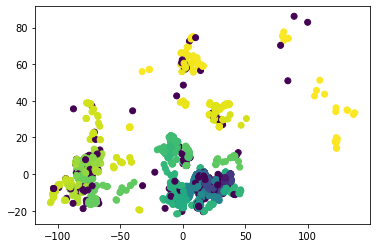



0.1 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


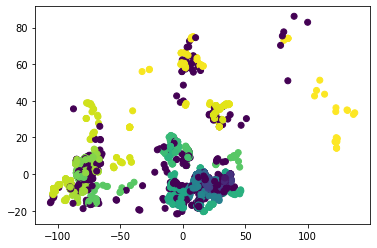



0.1 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


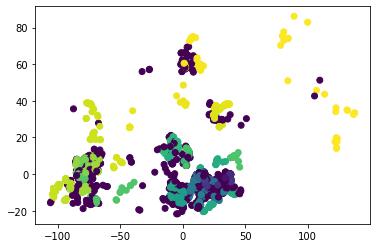



0.5 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


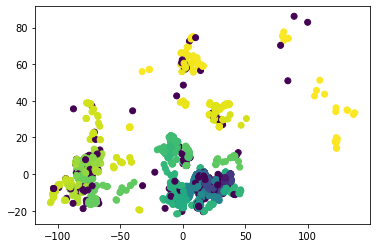



0.5 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


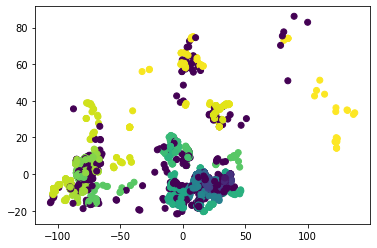



0.5 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


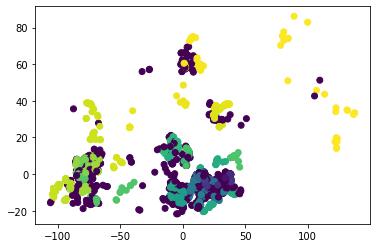



1 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


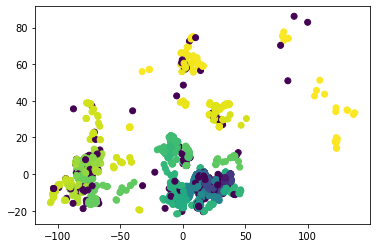



1 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


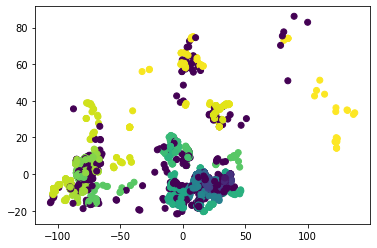



1 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


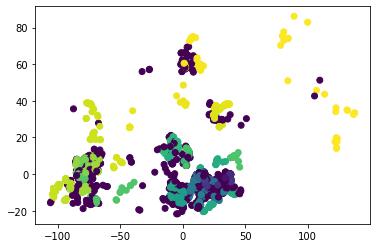



2 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


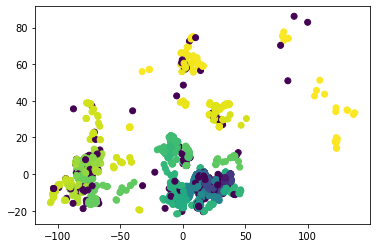



2 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


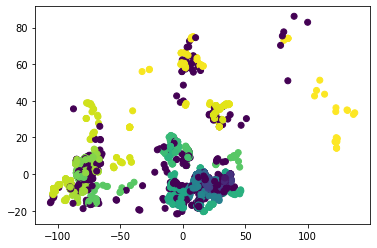



2 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


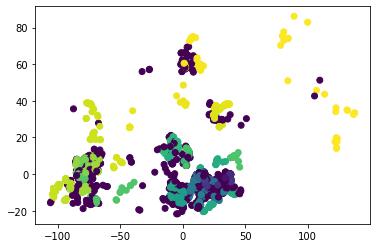



5 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


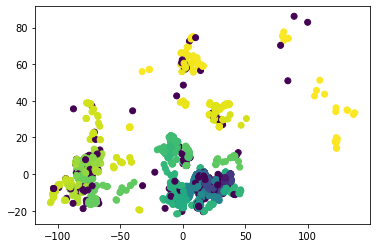



5 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


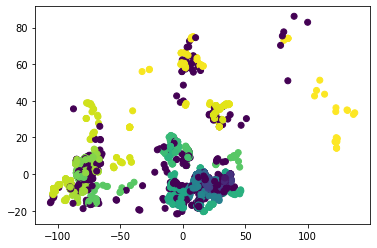



5 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


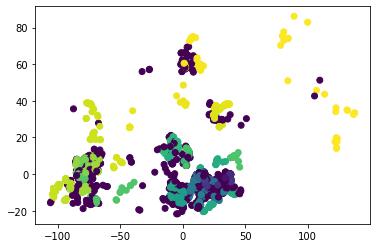



Best Silhouette score:  0.33412076484528563
Best Davis Bouldin score:  1.538990881709987


In [28]:
# With PCA components from features with greater than 0.01 correlation
X_01_optics = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI', 'Portugal',
                      'WHO', 'Centroid Admin1', 'Asia',  'OIE', 'Other', 'National authorities',
                      'Europe', 'Jordan', 'latitude', 'Exact', 'Centroid Locality', 
                      'observationYear', 'Uknown', 'longitude', 'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8',  
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer', 'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea', 'norm_sumAtRisk', 
                      'norm_sumCases', 'norm_sumDeaths', 'norm_sumDestroyed','norm_sumSlaughtered', 
                      'norm_humansAge','norm_humansAffected', 'norm_differenceInDays']].sample(n=4000)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01_optics)

silhouettes_optics = []
eps = [0.1, 0.5, 1, 2, 5]
min_samples = [2, 3, 5]
dbs = []

for ep in eps:
    for min_sample in min_samples:
        print(ep, 'eps and', min_sample, 'min samples.')
        optics_cluster = OPTICS(eps=ep, min_samples=min_sample)
        clusters = optics_cluster.fit_predict(pca_components) 
        try: 
            silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
            print('The silhoutte score of the OPTICS solution: ', silhouette)
            silhouettes_optics.append(silhouette)
            db = metrics.davies_bouldin_score(pca_components, clusters)
            print('The Davies Bouldin score of the OPTICS solution: ', db)
            dbs.append(db)
            plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
            plt.show()
            print('\n')
        except ValueError:
            print('\n')
            print('---------------------------------------------------')
            print('DBSCAN with', ep, 'eps and', min_sample, 'min samples was unable to find any clusters.')
            print('---------------------------------------------------')
            print('\n')
            
            
print('Best Silhouette score: ', max(silhouettes_optics))
print('Best Davis Bouldin score: ', min(dbs))

In [ ]:
most optimal configurations for agglomerative clsutering

spektral clustring